In [21]:
from transformers import pipeline
from nltk import sent_tokenize
import torch
from glob import glob
import pandas as pd
import numpy as np
import os 
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
theme_list = ["friendship","hope","sacrifice","battle","self development","betrayal","love","dialogue"]

In [3]:
model_name = "facebook/bart-large-mnli"

def load_model():
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
    )

    return theme_classifier

theme_classifier = load_model()

Device set to use mps:0


In [4]:
def load_subs_datasets(dataset_path):
    subtitles_paths = glob(dataset_path + '/*.ass')

    scripts = []
    episode_num = []
    seasons = []

    for path in subtitles_paths:
        filename = os.path.basename(path)
        
        with open(path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            lines = lines[27:]
            lines = [",".join(line.split(',')[9:]) for line in lines]
        
        lines = [line.replace('\\N', ' ') for line in lines]
        script = " ".join(lines)
        
        left_side = filename.split('-')[0].strip()  # "Naruto Season 1"
        # Sezon numarasını çek
        # Örneğin left_side.split() -> ["Naruto", "Season", "1"]
        season_num = int(left_side.split()[-1])
        episode = int(filename.split('-')[-1].split('.')[0].strip())

        scripts.append(script)
        episode_num.append(episode)
        seasons.append(season_num)  # direkt rakam olarak ekliyoruz

    df = pd.DataFrame({
        "episode": episode_num,
        "script": scripts
    })

    df.sort_values(["episode"], inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [5]:
dataset_path = "../data/Subtitles"
df = load_subs_datasets(dataset_path)
df.head()

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


In [6]:
script = df.iloc[0]['script']
script_sentences = sent_tokenize(script)
sentence_batch_size = 20
script_batches = []
for index in range(0,len(script_sentences),sentence_batch_size):
    sent = " ".join(script_sentences[index:index+sentence_batch_size])
    script_batches.append(sent) 

In [7]:
theme_outputs = []
for batch_text in script_batches[:2]:
    output = theme_classifier(
        batch_text,
        theme_list,
        multi_label=True,
        truncation=True
    )
    theme_outputs.append(output)


In [8]:
themes = {}
for output in theme_outputs:
    for label,score in zip(output['labels'],output['scores']):
        print(f"{label}: {score: .2f}") 
        if label not in themes:
            themes[label] = []
        themes[label].append(score)

dialogue:  0.98
betrayal:  0.94
battle:  0.85
sacrifice:  0.73
self development:  0.73
hope:  0.20
friendship:  0.06
love:  0.04
dialogue:  0.94
self development:  0.87
battle:  0.66
betrayal:  0.65
sacrifice:  0.63
hope:  0.20
friendship:  0.09
love:  0.03


In [9]:
def get_themes_inference(script):
    script_sentences = sent_tokenize(script)

    # Batch Sentence
    sentence_batch_size=20
    script_batches = []
    for index in range(0,len(script_sentences),sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)
    
    # Run Model
    theme_output = theme_classifier(
        script_batches[:2],
        theme_list,
        multi_label=True
    )

    # Wrangle Output 
    themes = {}
    for output in theme_output:
        for label,score in zip(output['labels'],output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)

    themes = {k:np.mean(v) for k,v in themes.items()} 

    return themes

In [10]:
df = df.head(2)
output_themes = df['script'].apply(get_themes_inference)
theme_df = pd.DataFrame(output_themes.tolist())

In [11]:
df[theme_df.columns] = theme_df
df

,episode,script,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,1,"A long time ago, a powerful demon fox appeared...",0.958543,0.792707,0.756409,0.680431,0.798157,0.201668,0.072628,0.034141
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",0.960605,0.429944,0.684843,0.570700,0.482806,0.154533,0.046261,0.173262


In [12]:
df = df.drop(columns=['dialogue'], axis=1)

In [19]:
theme_output = df.drop(["episode", "script"], axis=1).sum().reset_index()
theme_output.columns = ["theme", "score"]
theme_output

,theme,score
0,betrayal,1.222651
1,battle,1.441252
2,sacrifice,1.251131
3,self development,1.280963
4,hope,0.356201
5,friendship,0.118889
6,love,0.207403


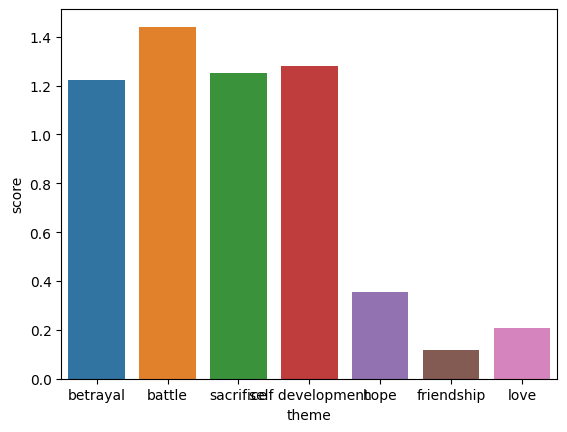

In [24]:
sns.barplot(data = theme_output, x= "theme", y="score")
plt.show()